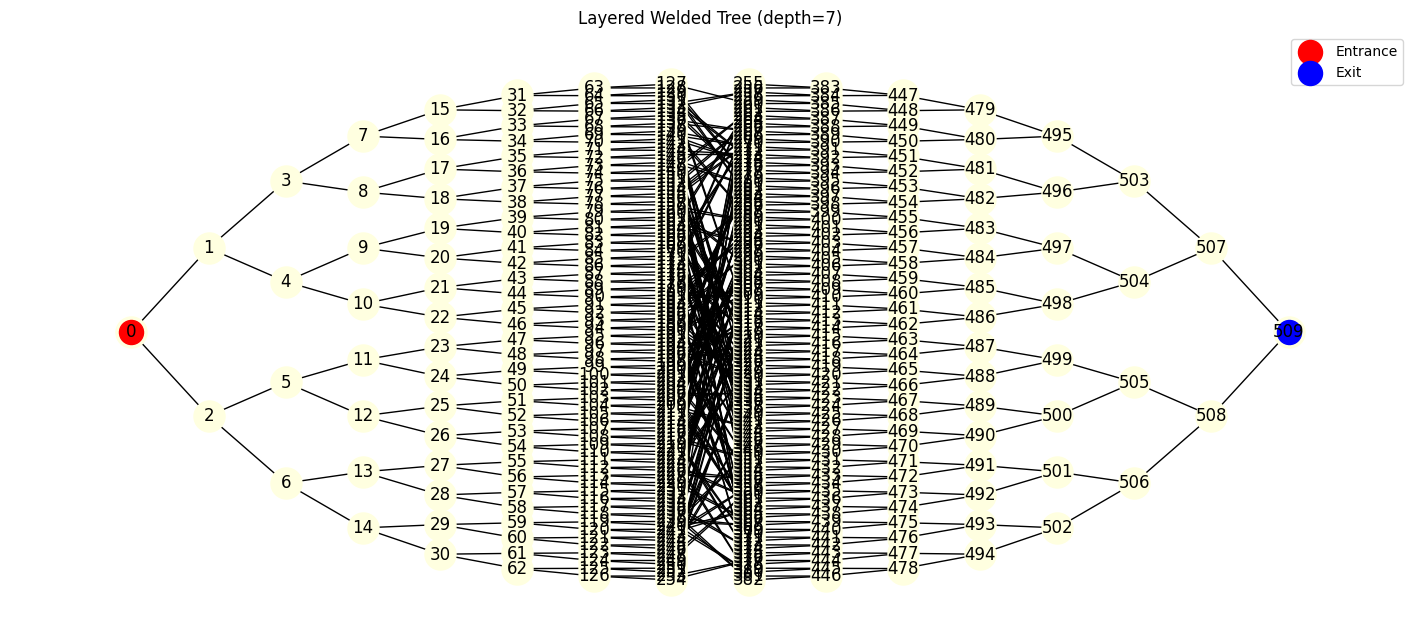

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time

def layered_welded_tree(depth, seed=42):
    """
    Creates a layered, undirected welded tree with clear left, middle, and right layers.
    After the welded layer, the tree converges toward the exit.
    All node labels are Python ints.
    The welding in the middle layer is random and controlled by the seed.
    """
    G = nx.Graph()
    layers = {}

    # Left binary tree (expanding)
    node = 0
    layers[0] = [node]  # Entrance
    node += 1
    for d in range(1, depth+1):
        layers[d] = []
        for parent in layers[d-1]:
            left = node
            right = node + 1
            G.add_edge(int(parent), int(left))
            G.add_edge(int(parent), int(right))
            layers[d].extend([int(left), int(right)])
            node += 2

    left_leaves = layers[depth]

    # Middle welded layer
    mid_layer = []
    for i in range(2**depth):
        mid_layer.append(node)
        node += 1
    layers[depth+1] = [int(x) for x in mid_layer]

    # Weld: each left leaf connects to two mid nodes (degree 3)
    np.random.seed(seed)
    perm = np.random.permutation(mid_layer)
    for i, l in enumerate(left_leaves):
        m1 = int(perm[i % len(mid_layer)])
        m2 = int(perm[(i+1) % len(mid_layer)])
        G.add_edge(int(l), m1)
        G.add_edge(int(l), m2)

    # Right binary tree (converging)
    right_layers = {}
    right_layers[depth+1] = [int(x) for x in mid_layer]
    curr_layer = [int(x) for x in mid_layer]
    for d in range(depth):
        next_layer = []
        for i in range(0, len(curr_layer), 2):
            parent = node
            G.add_edge(int(curr_layer[i]), int(parent))
            G.add_edge(int(curr_layer[i+1]), int(parent))
            next_layer.append(int(parent))
            node += 1
        right_layers[depth+2+d] = next_layer
        curr_layer = next_layer

    # No extra exit node: last layer is the exit
    exit_node = int(curr_layer[0])

    # Compose all layers for plotting
    all_layers = []
    for d in range(depth+1):
        all_layers.append(layers[d])
    all_layers.append(layers[depth+1])
    for d in range(depth+2, depth+2+depth):
        all_layers.append(right_layers[d])

    # Assign positions for plotting
    pos = {}
    for i, layer in enumerate(all_layers):
        y_step = 1.0 / (len(layer) + 1)
        for j, n in enumerate(layer):
            pos[int(n)] = (i, 1 - (j+1)*y_step)

    entrance = int(layers[0][0])
    # Relabel all nodes to int (in case)
    G = nx.relabel_nodes(G, lambda x: int(x))
    return G, pos, entrance, exit_node

# Example usage:
depth = 7
seed = 4
G, pos, entrance, exit_node = layered_welded_tree(depth, seed)

plt.figure(figsize=(14, 6))
nx.draw(G, pos, with_labels=True, node_color='lightyellow', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=[entrance], node_color='red', label='Entrance')
nx.draw_networkx_nodes(G, pos, nodelist=[exit_node], node_color='blue', label='Exit')
plt.title(f"Layered Welded Tree (depth={depth})")
plt.axis('off')
plt.legend()
plt.show()

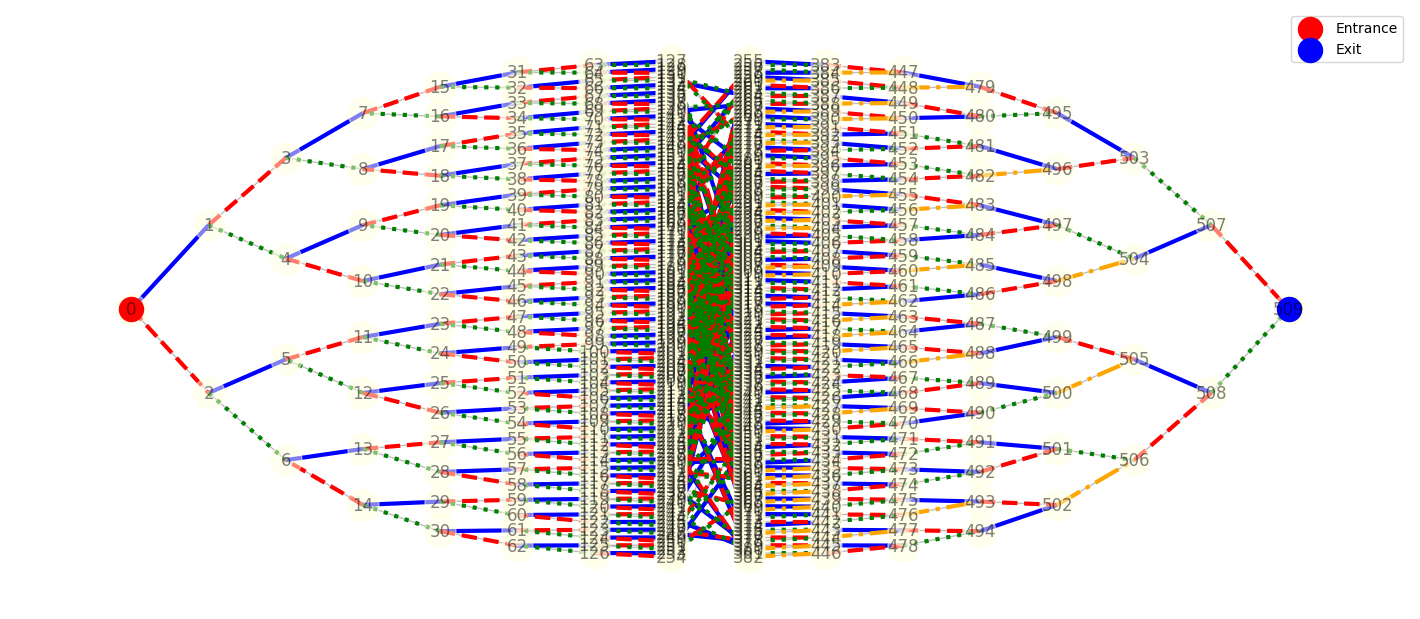


--- Checking tessellation 1 ---
Tessellation 1: no node overlaps (matching OK).
Tessellation 1: no duplicate edges.

--- Checking tessellation 2 ---
Tessellation 2: no node overlaps (matching OK).
Tessellation 2: no duplicate edges.

--- Checking tessellation 3 ---
Tessellation 3: no node overlaps (matching OK).
Tessellation 3: no duplicate edges.

--- Checking tessellation 4 ---
Tessellation 4: no node overlaps (matching OK).
Tessellation 4: no duplicate edges.
Edge overlap check complete.


In [ ]:
def compute_k_tessellations_layers(G, pos, k=4, split_last_vertex=False):
    """
    Partition the edges of G into k matchings (2-cliques), i.e., k tessellations.
    Optionally splits the last vertex (exit node) into two vertices (t1, t2) connected by a new edge.
    Returns a list of tessellations, each as a list of edges, and the modified graph and positions.
    """
    G_mod = G.copy()
    pos_mod = pos.copy()

    # --- Split the last vertex (exit node) into t1 and t2 ---
    if split_last_vertex:
        last_layer_x = max(pos[n][0] for n in pos)
        last_layer_nodes = [n for n in pos if abs(pos[n][0] - last_layer_x) < 1e-6]
        if len(last_layer_nodes) != 1:
            raise ValueError("Expected a single exit node in the last layer.")
        t = last_layer_nodes[0]
        neighbors = list(G_mod.neighbors(t))
        G_mod.remove_node(t)
        pos_mod.pop(t)
        t1 = f"{t}_1"
        t2 = f"{t}_2"
        G_mod.add_node(t1)
        G_mod.add_node(t2)
        G_mod.add_edge(t1, t2)
        for i, nbr in enumerate(neighbors):
            if i % 2 == 0:
                G_mod.add_edge(t1, nbr)
            else:
                G_mod.add_edge(t2, nbr)
        x, y = pos[t]
        pos_mod[t1] = (x, y + 0.03)
        pos_mod[t2] = (x, y - 0.03)

    # --- Use G_mod and pos_mod for everything below ---
    max_layer = int(max(pos_mod[n][0] for n in pos_mod))
    all_layers = []
    for d in range(max_layer + 1):
        all_layers.append([n for n in pos_mod if abs(pos_mod[n][0] - d) < 1e-6])

    tessellations = [[] for _ in range(k)]
    used = [set() for _ in range(k)]

    edges_by_layer = []
    for layer in all_layers:
        layer_edges = []
        for u in layer:
            for v in G_mod.neighbors(u):
                # Compare as strings to avoid int/str TypeError
                if str(u) < str(v):
                    layer_edges.append((u, v))
        edges_by_layer.append(layer_edges)

    seen = set()
    ordered_edges = []
    for layer_edges in edges_by_layer:
        for edge in layer_edges:
            # Sort edge as strings to avoid int/str TypeError in set
            edge_sorted = tuple(sorted(edge, key=str))
            if edge_sorted not in seen:
                ordered_edges.append(edge_sorted)
                seen.add(edge_sorted)

    for edge in ordered_edges:
        u, v = edge
        for i in range(k):
            if u not in used[i] and v not in used[i]:
                tessellations[i].append(edge)
                used[i].add(u)
                used[i].add(v)
                break
        else:
            min_conflicts = min(range(k), key=lambda i: len(used[i] & {u, v}))
            tessellations[min_conflicts].append(edge)

    return tessellations, G_mod, pos_mod

# Compute tessellations and get the modified graph/positions
tessellations, G_mod, pos_mod = compute_k_tessellations_layers(G, pos, k=4, split_last_vertex=False)

colors = ['blue', 'red', 'green', 'orange']
styles = ['solid', 'dashed', 'dotted', 'dashdot']

# Find the new split nodes (t1, t2)
last_layer_x = max(pos_mod[n][0] for n in pos_mod)
last_layer_nodes = [n for n in pos_mod if abs(pos_mod[n][0] - last_layer_x) < 1e-6]
if len(last_layer_nodes) == 2:
    t1, t2 = last_layer_nodes
else:
    t1 = t2 = None

plt.figure(figsize=(14, 6))
nx.draw(G_mod, pos_mod, with_labels=True, node_color='lightyellow', node_size=500, edge_color='gray', width=1, alpha=0.5)
nx.draw_networkx_nodes(G_mod, pos_mod, nodelist=[entrance], node_color='red', label='Entrance')
if t1 and t2:
    nx.draw_networkx_nodes(G_mod, pos_mod, nodelist=[t1, t2], node_color='blue', label='Exit (split)')
else:
    nx.draw_networkx_nodes(G_mod, pos_mod, nodelist=[exit_node], node_color='blue', label='Exit')

# Draw tessellations (use G_mod and pos_mod)
for tess, color, style in zip(tessellations, colors, styles):
    nx.draw_networkx_edges(G_mod, pos_mod, edgelist=tess, edge_color=color, width=3, style=style)

plt.axis('off')
plt.legend()
plt.show()

# --- Check for node overlaps and duplicate edges in each tessellation ---

for idx, tess in enumerate(tessellations):
    print(f"\n--- Checking tessellation {idx+1} ---")
    # Only consider 2-cliques (edges)
    edges = [tuple(sorted(edge, key=str)) for edge in tess if len(edge) == 2 or (isinstance(edge, tuple) and len(edge) == 2)]
    nodes_in_tess = set()
    overlap_found = False
    for u, v in edges:
        if u in nodes_in_tess or v in nodes_in_tess:
            print(f"Tessellation {idx+1} is not a matching! Edge ({u}, {v}) shares a node.")
            overlap_found = True
        nodes_in_tess.add(u)
        nodes_in_tess.add(v)
    if not overlap_found:
        print(f"Tessellation {idx+1}: no node overlaps (matching OK).")

    edge_set = set(edges)
    if len(edge_set) != len(edges):
        print(f"Duplicate edges found in tessellation {idx+1}!")
    else:
        print(f"Tessellation {idx+1}: no duplicate edges.")

# --- Check for edges appearing in more than one tessellation ---
all_edges = {}
for idx, tess in enumerate(tessellations):
    edges = [tuple(sorted(edge, key=str)) for edge in tess if len(edge) == 2 or (isinstance(edge, tuple) and len(edge) == 2)]
    for e in edges:
        if e in all_edges:
            print(f"Edge {e} appears in tessellation {all_edges[e]+1} and {idx+1}")
        else:
            all_edges[e] = idx
print("Edge overlap check complete.")

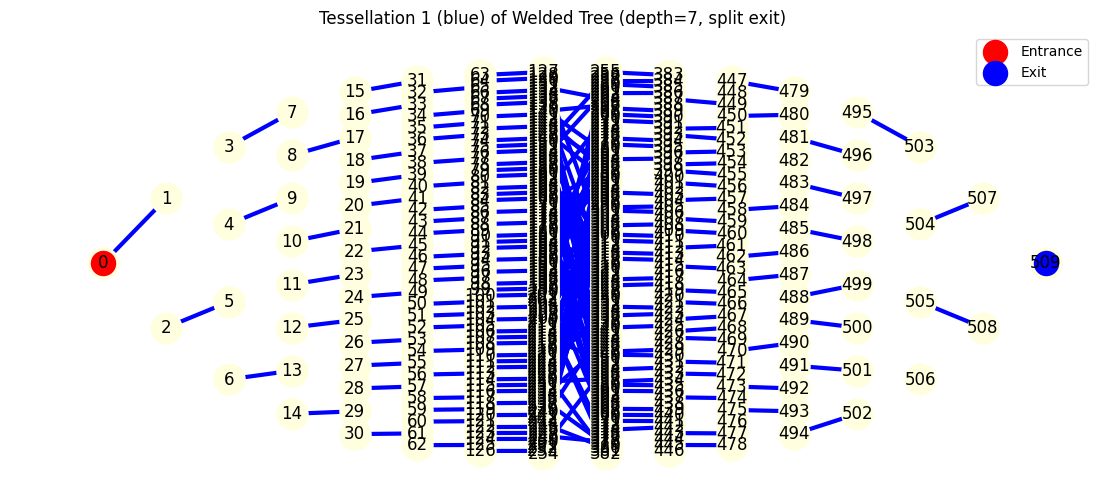

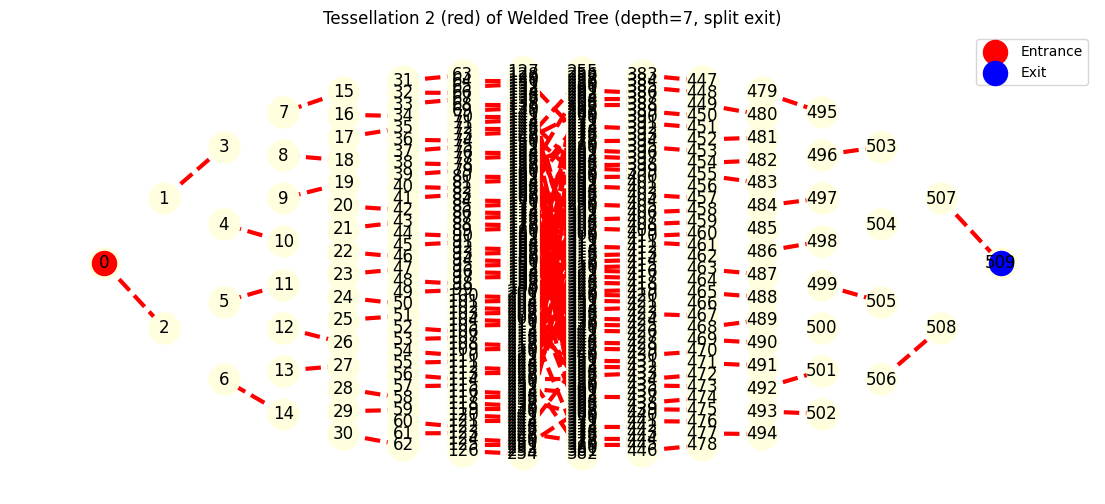

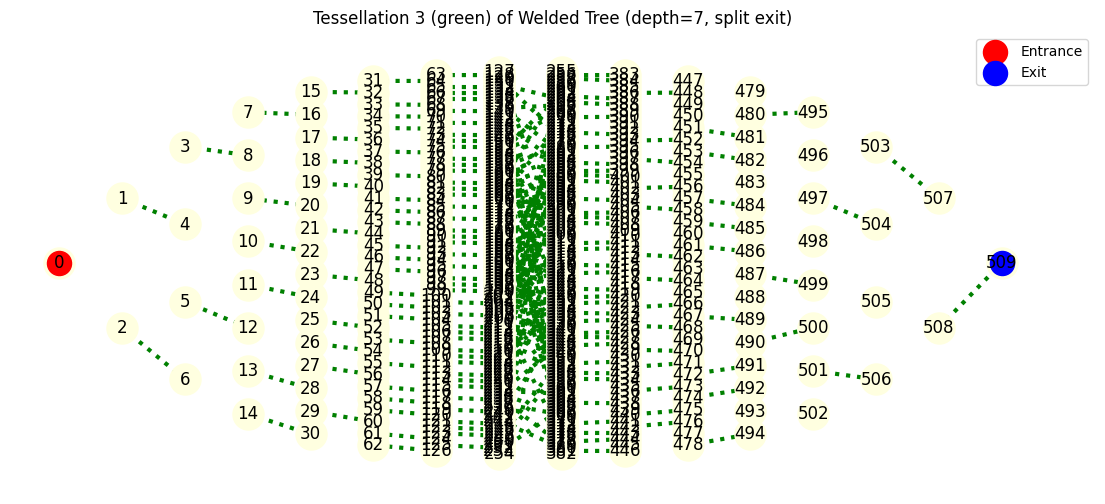

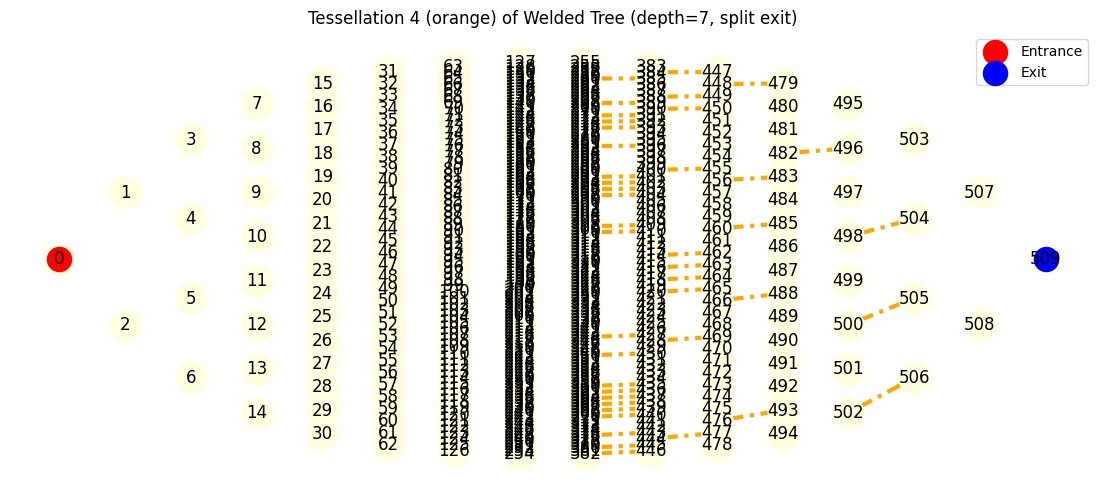

In [ ]:
# Output each tessellation separately
for idx, (tess, color, style) in enumerate(zip(tessellations, colors, styles)):
    plt.figure(figsize=(14, 6))
    # Draw all nodes in their modified positions
    nx.draw_networkx_nodes(G_mod, pos_mod, node_color='lightyellow', node_size=500)
    nx.draw_networkx_labels(G_mod, pos_mod)
    # Highlight entrance and exit (split)
    nx.draw_networkx_nodes(G_mod, pos_mod, nodelist=[entrance], node_color='red', label='Entrance')
    if t1 and t2:
        nx.draw_networkx_nodes(G_mod, pos_mod, nodelist=[t1, t2], node_color='blue', label='Exit (split)')
    else:
        nx.draw_networkx_nodes(G_mod, pos_mod, nodelist=[exit_node], node_color='blue', label='Exit')
    # Draw only the edges of this tessellation
    nx.draw_networkx_edges(G_mod, pos_mod, edgelist=tess, edge_color=color, width=3, style=style)
    plt.title(f"Tessellation {idx+1} ({color}) of Welded Tree (depth={depth}, split exit)")
    plt.axis('off')
    plt.legend()
    plt.show()

In [ ]:
from IPython.display import display

def compose_welded_tree_walk_operator_with_marked(
    G, node_list, tessellations_dict, marked_node, theta=np.pi/2, verbose=True
):
    """
    Builds the quantum walk operator U = R_orange R_green R_blue R_red R_marked,
    where R_marked = I - 2|t><t| and |t> is the basis state of the marked (exit) node.
    Assumes tessellations_dict is a dict: color -> list of cliques (each clique is a tuple of nodes).
    """
    def get_alpha_vectors(tessellation, node_list):
        alpha_vectors = []
        for clique in tessellation:
            if len(clique) == 1:
                vec = np.zeros(len(node_list), dtype=np.complex128)
                idx = node_list.index(clique[0])
                vec[idx] = 1.0
                alpha_vectors.append(vec)
            elif len(clique) == 2:
                vec = np.zeros(len(node_list), dtype=np.complex128)
                idx1 = node_list.index(clique[0])
                idx2 = node_list.index(clique[1])
                vec[idx1] = 1/np.sqrt(2)
                vec[idx2] = 1/np.sqrt(2)
                alpha_vectors.append(vec)
        return alpha_vectors

    def build_projector(alpha_vectors):
        n = len(alpha_vectors[0])
        P = np.zeros((n, n), dtype=np.complex128)
        for vec in alpha_vectors:
            P += np.outer(vec, np.conj(vec))
        return P

    def build_reflection_operator(P):
        n = P.shape[0]
        I = np.eye(n, dtype=np.complex128)
        W = I - 2 * P
        return W

    def build_R(W, theta, color=None):
        n = W.shape[0]
        I = np.eye(n, dtype=np.complex128)
        R = np.cos(theta) * I + 1j * np.sin(theta) * W
        # --- Unitarity check ---
        RdagR = R.conj().T @ R
        if verbose:
            if not np.allclose(RdagR, np.eye(n), atol=1e-10):
                print(f"Warning: build_R ({color}) produced a non-unitary operator! Max deviation:", np.max(np.abs(RdagR - np.eye(n))))
            else:
                print(f"build_R: operator ({color}) is unitary (within tolerance).", np.max(np.abs(RdagR - np.eye(n))))
        return R

    color_order = ['red', 'blue', 'green', 'orange']
    R_list = []
    for color in color_order:
        tess = tessellations_dict.get(color, [])
        if not tess:
            continue
        alpha = get_alpha_vectors(tess, node_list)
        if not alpha:
            continue
        # --- Orthonormality check ---
        alpha_mat = np.stack(alpha)
        overlap = alpha_mat @ alpha_mat.conj().T
        max_offdiag = np.max(np.abs(overlap - np.eye(len(alpha))))
        if verbose:
            if max_offdiag > 1e-10:
                print(f"Warning: |alpha> vectors for {color} are NOT orthonormal! Max off-diagonal: {max_offdiag:.2e}")
            else:
                print(f"|alpha> vectors for {color} are orthonormal (max off-diagonal: {max_offdiag:.2e})")
        P = build_projector(alpha)
        W = build_reflection_operator(P)
        R = build_R(W, theta, color=color)
        R_list.append((color, R))

    # Build the marked vertex reflection R_marked = I - 2|t><t|
    n = len(node_list)
    I = np.eye(n, dtype=np.complex128)
    t_vec = np.zeros(n, dtype=np.complex128)
    idx = node_list.index(marked_node)
    t_vec[idx] = 1.0
    P_t = np.outer(t_vec, np.conj(t_vec))
    R_marked = I - 2 * P_t

    print("Operator composition order (from right to left):")
    print("  [marked] * " + " * ".join([color for color, _ in R_list]))

    # Compose U = R_orange * R_green * R_blue * R_red * R_marked
    U = R_marked
    for color, R in R_list:
        U = np.dot(R, U)
    return U


# ...existing code...

# After computing tessellations, G_mod, pos_mod:
tessellations, G_mod, pos_mod = compute_k_tessellations_layers(G, pos, k=4, split_last_vertex=True)

# Always update node_list and tessellation_cliques from the new G_mod
node_list = sorted(G_mod.nodes(), key=str)
tessellation_cliques = []
for tess in tessellations:
    cliques = [tuple(edge) for edge in tess]
    covered = set()
    for edge in tess:
        covered.update(edge)
    singletons = [(n,) for n in node_list if n not in covered]
    cliques.extend(singletons)
    tessellation_cliques.append(cliques)

tessellations_dict = {
    'red': tessellation_cliques[colors.index('red')],
    'blue': tessellation_cliques[colors.index('blue')],
    'green': tessellation_cliques[colors.index('green')],
    'orange': tessellation_cliques[colors.index('orange')],
}

# Find the new split nodes (t1, t2)
last_layer_x = max(pos_mod[n][0] for n in pos_mod)
last_layer_nodes = [n for n in pos_mod if abs(pos_mod[n][0] - last_layer_x) < 1e-6]
if len(last_layer_nodes) == 2:
    t1, t2 = last_layer_nodes
else:
    t1 = t2 = None

# Mark the exit node (or t1/t2 if split_last_vertex=True)
if t1 and t2:
    marked_node = t1  # or t2, or [t1, t2] if you want a superposition
else:
    marked_node = exit_node

# Now you can safely call the walk operator function
U = compose_welded_tree_walk_operator_with_marked(
    G_mod, node_list, tessellations_dict, marked_node, theta=np.pi/2, verbose=True
)
print("Quantum walk operator U constructed. Shape:", U.shape)
# ...existing code...

# --- Check unitarity: U^† U (should be close to identity) ---
UdagU = U.conj().T @ U
print("U^† U =\n", UdagU)
print("Max deviation from identity:", np.max(np.abs(UdagU - np.eye(U.shape[0]))))


|alpha> vectors for red are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (red) is unitary (within tolerance). 4.440892098500626e-16
|alpha> vectors for blue are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (blue) is unitary (within tolerance). 4.440892098500626e-16
|alpha> vectors for green are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (green) is unitary (within tolerance). 4.440892098500626e-16
|alpha> vectors for orange are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (orange) is unitary (within tolerance). 4.440892098500626e-16
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Quantum walk operator U constructed. Shape: (511, 511)
U^† U =
 [[ 1.00000000e+00+3.81107727e-33j -2.35603563e-47-6.07716336e-64j
  -2.35603563e-47+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-2.35603563e-47+6.07716336e-64j  1.00000000e+

Computing tessellations with split_last_vertex=True...
Exit nodes (split): 509_1, 509_2
Building quantum walk operator...
|alpha> vectors for red are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (red) is unitary (within tolerance). 4.440892098500626e-16
|alpha> vectors for blue are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (blue) is unitary (within tolerance). 4.440892098500626e-16
|alpha> vectors for green are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (green) is unitary (within tolerance). 4.440892098500626e-16
|alpha> vectors for orange are orthonormal (max off-diagonal: 2.22e-16)
build_R: operator (orange) is unitary (within tolerance). 4.440892098500626e-16
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Quantum walk operator U constructed. Shape: (511, 511)
Running quantum walk...
Step 0: norm = 1.0000000000, prob_exit = 0.000000
Step 100: norm = 1.0000000000, prob_exit = 0.000000
Step 200: n

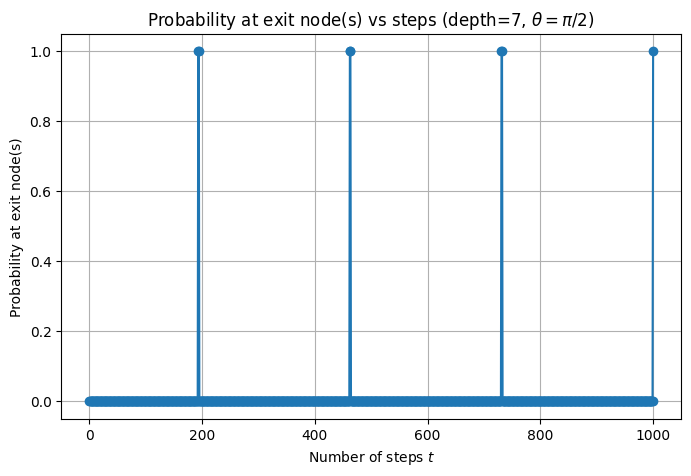

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
theta = np.pi / 2
max_steps = 1000

print("Computing tessellations with split_last_vertex=True...")
tessellations, G_mod, pos_mod = compute_k_tessellations_layers(G, pos, k=4, split_last_vertex=True)

# Find the new split nodes (t1, t2)
last_layer_x = max(pos_mod[n][0] for n in pos_mod)
last_layer_nodes = [n for n in pos_mod if abs(pos_mod[n][0] - last_layer_x) < 1e-6]
if len(last_layer_nodes) == 2:
    t1, t2 = last_layer_nodes
    print(f"Exit nodes (split): {t1}, {t2}")
else:
    t1 = t2 = None
    print(f"Exit node: {exit_node}")

# Prepare cliques for each tessellation (each edge as a 2-clique, plus singletons)
all_nodes = sorted(G_mod.nodes(), key=str)
tessellation_cliques = []
for tess in tessellations:
    cliques = [tuple(edge) for edge in tess]
    covered = set()
    for edge in tess:
        covered.update(edge)
    singletons = [(n,) for n in all_nodes if n not in covered]
    cliques.extend(singletons)
    tessellation_cliques.append(cliques)

colors = ['blue', 'red', 'green', 'orange']
tessellations_dict = {
    'red': tessellation_cliques[colors.index('red')],
    'blue': tessellation_cliques[colors.index('blue')],
    'green': tessellation_cliques[colors.index('green')],
    'orange': tessellation_cliques[colors.index('orange')],
}

# Marked node for the walk operator
if t1 and t2:
    marked_node = t1
else:
    marked_node = exit_node

node_list = all_nodes
print("Building quantum walk operator...")
U = compose_welded_tree_walk_operator_with_marked(
    G_mod, node_list, tessellations_dict, marked_node, theta=theta, verbose=True
)
print(f"Quantum walk operator U constructed. Shape: {U.shape}")

# Use entrance index and both t1/t2 as exit indices
entrance_idx = all_nodes.index(entrance)
if t1 and t2:
    exit_indices = [all_nodes.index(t1), all_nodes.index(t2)]
else:
    exit_indices = [all_nodes.index(exit_node)]
n = len(all_nodes)

# Initial state: basis state at the entrance node (root/left node)
psi_0 = np.zeros(n, dtype=complex)
psi_0[entrance_idx] = 1.0

print("Running quantum walk...")
probs = []
state = psi_0.copy()
for t in range(max_steps + 1):
    prob_exit = sum(np.abs(state[idx])**2 for idx in exit_indices)
    probs.append(prob_exit)
    norm = np.linalg.norm(state)
    if t % 100 == 0:
        print(f"Step {t}: norm = {norm:.10f}, prob_exit = {prob_exit:.6f}")
    if norm > 0:
        state = state / norm  # Normalize the state at every step
    state = U @ state

# Plot probability vs steps
plt.figure(figsize=(8, 5))
plt.plot(range(max_steps + 1), probs, marker='o')
plt.xlabel('Number of steps $t$')
plt.ylabel('Probability at exit node(s)')
plt.title(rf'Probability at exit node(s) vs steps (depth={depth}, $\theta = \pi/2$)')
plt.grid(True)
plt.show()

Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator c

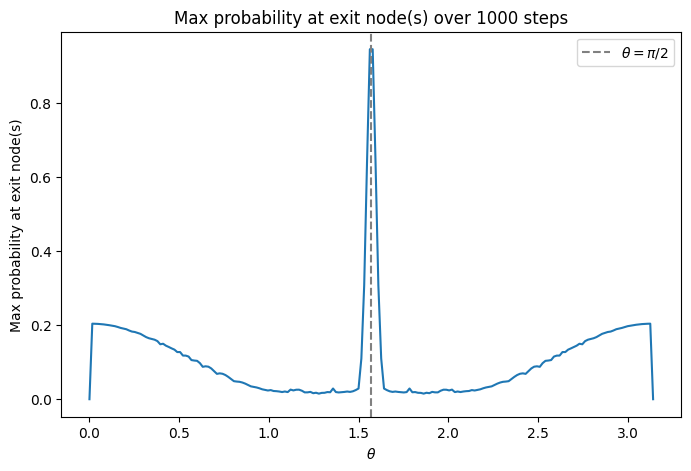

In [ ]:
def staggered_walk_max_probability_vs_theta(N_steps, thetas, all_nodes, entrance, exit_nodes):
    """
    For each theta, simulate the staggered quantum walk and record the maximum probability
    at the exit node(s) over all steps up to N_steps.
    Plots the maximum probability at the exit node(s) for each theta.
    """
    n = len(all_nodes)
    entrance_idx = all_nodes.index(entrance)
    if isinstance(exit_nodes, (list, tuple, set)):
        exit_indices = [all_nodes.index(n) for n in exit_nodes]
    else:
        exit_indices = [all_nodes.index(exit_nodes)]
    max_probs = []
    for theta in thetas:
        U = compose_welded_tree_walk_operator_with_marked(
            G_mod, node_list, tessellations_dict, marked_node, theta=theta, verbose=False
        )
        psi = np.zeros(len(node_list), dtype=complex)
        psi[entrance_idx] = 1.0
        probs_steps = []
        for _ in range(N_steps):
            psi = U @ psi
            prob_exit = sum(np.abs(psi[idx])**2 for idx in exit_indices)
            probs_steps.append(prob_exit)
        max_probs.append(np.max(probs_steps))
    plt.figure(figsize=(8,5))
    plt.plot(thetas, max_probs)
    plt.axvline(np.pi/2, color='gray', linestyle='--', label=r'$\theta = \pi/2$')
    plt.xlabel(r'$\theta$')
    plt.ylabel('Max probability at exit node(s)')
    plt.title(f'Max probability at exit node(s) over {N_steps} steps')
    plt.legend()
    plt.show()
    return max_probs

# Example usage:
N_steps = 1000
thetas = np.linspace(0, 3.1415926535, 200)

# Find the new split nodes (t1, t2) after tessellation
last_layer_x = max(pos_mod[n][0] for n in pos_mod)
last_layer_nodes = [n for n in pos_mod if abs(pos_mod[n][0] - last_layer_x) < 1e-6]
if len(last_layer_nodes) == 2:
    exit_nodes = last_layer_nodes  # Use both split nodes
else:
    exit_nodes = exit_node         # Use the original exit node

probs = staggered_walk_max_probability_vs_theta(
    N_steps,
    thetas,
    all_nodes,
    entrance,
    exit_nodes
)


Best θ: 1.5787 (max probability at exit after 1000 steps: 0.9445)
Operator composition order (from right to left):
  [marked] * red * blue * green * orange


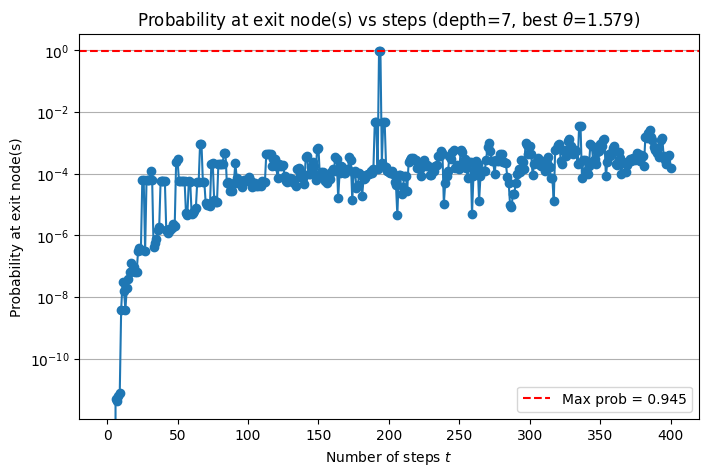

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
max_steps = 400

# Use the same thetas and probs as in the previous cell
# probs = staggered_walk_probability_vs_theta(...), so probs is already available

# Find best theta from previous results
best_theta_idx = np.argmax(probs)
best_theta = thetas[best_theta_idx]
print(f"Best θ: {best_theta:.4f} (max probability at exit after {N_steps} steps: {probs[best_theta_idx]:.4f})")

# Now run the walk with this best θ and plot probability vs steps
U = compose_welded_tree_walk_operator_with_marked(
    G_mod, node_list, tessellations_dict, marked_node, theta=best_theta, verbose=False
)

entrance_idx = all_nodes.index(entrance)
if isinstance(exit_nodes, (list, tuple, set)):
    exit_indices = [all_nodes.index(n) for n in exit_nodes]
else:
    exit_indices = [all_nodes.index(exit_nodes)]
n = len(all_nodes)

psi_0 = np.zeros(n, dtype=complex)
psi_0[entrance_idx] = 1.0

probs_steps = []
state = psi_0.copy()
for t in range(max_steps + 1):
    prob_exit = sum(np.abs(state[idx])**2 for idx in exit_indices)
    probs_steps.append(prob_exit)
    norm = np.linalg.norm(state)
    if norm > 0:
        state = state / norm
    state = U @ state

max_prob = max(probs_steps)

plt.figure(figsize=(8, 5))
plt.plot(range(max_steps + 1), probs_steps, marker='o')
plt.axhline(max_prob, color='red', linestyle='--', label=f'Max prob = {max_prob:.3g}')
plt.yscale('log')
plt.xlabel('Number of steps $t$')
plt.ylabel('Probability at exit node(s)')
plt.title(rf'Probability at exit node(s) vs steps (depth={depth}, best $\theta$={best_theta:.3f})')
plt.grid(True, which='both', axis='y')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

depths = [7, 7]
seeds = [2, 7]
max_steps = 500
N_steps_theta = 1000
thetas = np.linspace(0, np.pi, 200)
colors_plot = ['tab:blue', 'tab:orange']

all_probs_steps = []
all_labels = []

for i, (depth, seed) in enumerate(zip(depths, seeds)):
    print(f"\n--- Processing depth={depth}, seed={seed} ---")
    # --- Build welded tree ---
    print(f"Building welded tree with seed={seed}...")
    G, pos, entrance, exit_node = layered_welded_tree(depth, seed)

    # --- Tessellate WITHOUT splitting the exit node ---
    print("Computing tessellations (no split)...")
    tessellations, G_mod, pos_mod = compute_k_tessellations_layers(G, pos, k=4, split_last_vertex=False)
    node_list = sorted(G_mod.nodes(), key=str)
    colors = ['blue', 'red', 'green', 'orange']

    # Prepare cliques for each tessellation (each edge as a 2-clique, plus singletons)
    tessellation_cliques = []
    for tess in tessellations:
        cliques = [tuple(edge) for edge in tess]
        covered = set()
        for edge in tess:
            covered.update(edge)
        singletons = [(n,) for n in node_list if n not in covered]
        cliques.extend(singletons)
        tessellation_cliques.append(cliques)

    tessellations_dict = {
        'red': tessellation_cliques[colors.index('red')],
        'blue': tessellation_cliques[colors.index('blue')],
        'green': tessellation_cliques[colors.index('green')],
        'orange': tessellation_cliques[colors.index('orange')],
    }

    # Exit node is not split
    exit_nodes = exit_node
    marked_node = exit_node
    print(f"Exit node: {exit_node}")

    # --- Find best theta ---
    print("Scanning theta values to find best theta...")
    probs_theta = []
    entrance_idx = node_list.index(entrance)
    exit_indices = [node_list.index(exit_node)]
    for idx_theta, theta in enumerate(thetas):
        if idx_theta % 50 == 0:
            print(f"  Theta scan progress: {idx_theta}/{len(thetas)}")
        U = compose_welded_tree_walk_operator_with_marked(
            G_mod, node_list, tessellations_dict, marked_node, theta=theta, verbose=False
        )
        psi = np.zeros(len(node_list), dtype=complex)
        psi[entrance_idx] = 1.0
        probs_steps = []
        for _ in range(N_steps_theta):
            psi = U @ psi
            prob_exit = np.abs(psi[exit_indices[0]])**2
            probs_steps.append(prob_exit)
        probs_theta.append(np.max(probs_steps))
    best_theta_idx = np.argmax(probs_theta)
    best_theta = thetas[best_theta_idx]
    print(f"Best theta for depth={depth}, seed={seed}: {best_theta:.4f} (max prob: {probs_theta[best_theta_idx]:.4f})")

    # --- Run walk for best theta and collect probability vs steps ---
    print(f"Running quantum walk for best theta={best_theta:.4f}...")
    U = compose_welded_tree_walk_operator_with_marked(
        G_mod, node_list, tessellations_dict, marked_node, theta=best_theta, verbose=False
    )
    psi_0 = np.zeros(len(node_list), dtype=complex)
    psi_0[entrance_idx] = 1.0
    probs_steps = []
    state = psi_0.copy()
    for t in range(max_steps + 1):
        if t % 100 == 0:
            print(f"  Step {t}/{max_steps}")
        prob_exit = np.abs(state[exit_indices[0]])**2
        probs_steps.append(prob_exit)
        norm = np.linalg.norm(state)
        if norm > 0:
            state = state / norm
        state = U @ state

    all_probs_steps.append(probs_steps)
    all_labels.append(f"depth={depth}, seed={seed}, best θ={best_theta:.3f}")

print("\n--- Plotting all curves together ---")
plt.figure(figsize=(10, 6))
for probs_steps, label, color in zip(all_probs_steps, all_labels, colors_plot):
    plt.plot(range(max_steps + 1), probs_steps, marker='', label=label, color=color)
plt.xlabel('Number of steps $t$')
plt.ylabel('Probability at exit node')
plt.title('Probability at exit node vs steps for depth=7, seeds 2 and 7 (best θ for each)')
plt.legend()
plt.grid(True)
plt.show()


--- Processing depth=7, seed=2 ---
Building welded tree with seed=2...
Computing tessellations (no split)...
Exit node: 509
Scanning theta values to find best theta...
  Theta scan progress: 0/200
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green *

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

depths = [5, 6, 7]
max_steps = 500
N_steps_theta = 1000
thetas = np.linspace(0, np.pi, 200)
colors_plot = ['tab:blue', 'tab:orange', 'tab:green']

all_probs_steps = []
all_labels = []

for i, depth in enumerate(depths):
    print(f"\n--- Processing depth={depth} ---")
    # --- Build welded tree ---
    seed = 42 + i  # Different seed for each depth for reproducibility
    print(f"Building welded tree with seed={seed}...")
    G, pos, entrance, exit_node = layered_welded_tree(depth, seed)

    # --- Tessellate with split_last_vertex=True ---
    print("Computing tessellations...")
    tessellations, G_mod, pos_mod = compute_k_tessellations_layers(G, pos, k=4, split_last_vertex=True)
    node_list = sorted(G_mod.nodes(), key=str)
    colors = ['blue', 'red', 'green', 'orange']

    # Prepare cliques for each tessellation (each edge as a 2-clique, plus singletons)
    tessellation_cliques = []
    for tess in tessellations:
        cliques = [tuple(edge) for edge in tess]
        covered = set()
        for edge in tess:
            covered.update(edge)
        singletons = [(n,) for n in node_list if n not in covered]
        cliques.extend(singletons)
        tessellation_cliques.append(cliques)

    tessellations_dict = {
        'red': tessellation_cliques[colors.index('red')],
        'blue': tessellation_cliques[colors.index('blue')],
        'green': tessellation_cliques[colors.index('green')],
        'orange': tessellation_cliques[colors.index('orange')],
    }

    # Find the new split nodes (t1, t2)
    last_layer_x = max(pos_mod[n][0] for n in pos_mod)
    last_layer_nodes = [n for n in pos_mod if abs(pos_mod[n][0] - last_layer_x) < 1e-6]
    if len(last_layer_nodes) == 2:
        t1, t2 = last_layer_nodes
        exit_nodes = [t1, t2]
        marked_node = t1
        print(f"Exit nodes (split): {t1}, {t2}")
    else:
        t1 = t2 = None
        exit_nodes = exit_node
        marked_node = exit_node
        print(f"Exit node: {exit_node}")

    # --- Find best theta ---
    print("Scanning theta values to find best theta...")
    probs_theta = []
    entrance_idx = node_list.index(entrance)
    if isinstance(exit_nodes, (list, tuple, set)):
        exit_indices = [node_list.index(n) for n in exit_nodes]
    else:
        exit_indices = [node_list.index(exit_nodes)]
    for idx_theta, theta in enumerate(thetas):
        if idx_theta % 50 == 0:
            print(f"  Theta scan progress: {idx_theta}/{len(thetas)}")
        U = compose_welded_tree_walk_operator_with_marked(
            G_mod, node_list, tessellations_dict, marked_node, theta=theta, verbose=False
        )
        psi = np.zeros(len(node_list), dtype=complex)
        psi[entrance_idx] = 1.0
        probs_steps = []
        for _ in range(N_steps_theta):
            psi = U @ psi
            prob_exit = sum(np.abs(psi[idx])**2 for idx in exit_indices)
            probs_steps.append(prob_exit)
        probs_theta.append(np.max(probs_steps))
    best_theta_idx = np.argmax(probs_theta)
    best_theta = thetas[best_theta_idx]
    print(f"Best theta for depth={depth}: {best_theta:.4f} (max prob: {probs_theta[best_theta_idx]:.4f})")

    # --- Run walk for best theta and collect probability vs steps ---
    print(f"Running quantum walk for best theta={best_theta:.4f}...")
    U = compose_welded_tree_walk_operator_with_marked(
        G_mod, node_list, tessellations_dict, marked_node, theta=best_theta, verbose=False
    )
    psi_0 = np.zeros(len(node_list), dtype=complex)
    psi_0[entrance_idx] = 1.0
    probs_steps = []
    state = psi_0.copy()
    for t in range(max_steps + 1):
        if t % 100 == 0:
            print(f"  Step {t}/{max_steps}")
        prob_exit = sum(np.abs(state[idx])**2 for idx in exit_indices)
        probs_steps.append(prob_exit)
        norm = np.linalg.norm(state)
        if norm > 0:
            state = state / norm
        state = U @ state

    all_probs_steps.append(probs_steps)
    all_labels.append(f"depth={depth}, best θ={best_theta:.3f}")

print("\n--- Plotting all curves together ---")
plt.figure(figsize=(10, 6))
for probs_steps, label, color in zip(all_probs_steps, all_labels, colors_plot):
    plt.plot(range(max_steps + 1), probs_steps, marker='', label=label, color=color)
plt.xlabel('Number of steps $t$')
plt.ylabel('Probability at exit node(s)')
plt.title('Probability at exit node(s) vs steps for different depths (best θ for each)')
plt.legend()
plt.grid(True)
plt.show()


--- Processing depth=5 ---
Building welded tree with seed=42...
Computing tessellations...
Exit nodes (split): 125_1, 125_2
Scanning theta values to find best theta...
  Theta scan progress: 0/200
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green * orange
Operator composition order (from right to left):
  [marked] * red * blue * green *

KeyboardInterrupt: 